# Constants

In [1]:
IALAB_USER = 'mrearle'

In [2]:
!which python
!ls
!pwd

/home/mrearle/repos/360-visualization/r2r/bin/python
LICENSE		     logs
README.md	     metadata_parser
connectivity	     objects_visualization.ipynb
data		     r2r
data_explorer.ipynb  requirements.txt
datax		     slurm_scripts
img		     trajectory_visualization_v2.ipynb
/home/mrearle/repos/360-visualization


# Imports

In [3]:
import os
import sys

In [4]:
matterport_build_path = f'/home/{IALAB_USER}/datasets/Matterport3DSimulator/build'
metadata_script_path = f'/home/{IALAB_USER}/repos/360-visualization/metadata_parser'

In [5]:
if matterport_build_path not in sys.path:
    sys.path.append(matterport_build_path)

if metadata_script_path not in sys.path:
    sys.path.append(metadata_script_path)

sys.path

['/home/mrearle/repos/360-visualization/r2r/lib/python36.zip',
 '/home/mrearle/repos/360-visualization/r2r/lib/python3.6',
 '/home/mrearle/repos/360-visualization/r2r/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '',
 '/home/mrearle/repos/360-visualization/r2r/lib/python3.6/site-packages',
 '/home/mrearle/repos/360-visualization/r2r/lib/python3.6/site-packages/IPython/extensions',
 '/mnt-homes/kraken/mrearle/.ipython',
 '/home/mrearle/datasets/Matterport3DSimulator/build',
 '/home/mrearle/repos/360-visualization/metadata_parser']

In [6]:
import json
import sys
import MatterSim
import time
import numpy as np
import skimage.transform
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

from parse_house_segmentations import HouseSegmentationFile

# Setup Simulator

In [7]:
# load navigation graph to calculate the relative heading of the next location
def load_nav_graph(graph_path):
    with open(graph_path) as f:
        G = nx.Graph()
        positions = {}
        data = json.load(f)
        for i,item in enumerate(data):
            if item['included']:
                for j,conn in enumerate(item['unobstructed']):
                    if conn and data[j]['included']:
                        positions[item['image_id']] = np.array([item['pose'][3], 
                                item['pose'][7], item['pose'][11]]);
                        assert data[j]['unobstructed'][i], 'Graph should be undirected'
                        G.add_edge(item['image_id'],data[j]['image_id'])
        nx.set_node_attributes(G, values=positions, name='position')
    return G

def compute_rel_heading(graph, current_viewpoint, current_heading, next_viewpoint):
    if current_viewpoint == next_viewpoint:
        return 0.
    target_rel = graph.nodes[next_viewpoint]['position'] - graph.nodes[current_viewpoint]['position']
    target_heading = np.pi/2.0 - np.arctan2(target_rel[1], target_rel[0]) # convert to rel to y axis
    
    rel_heading = target_heading - current_heading
    # normalize angle into turn into [-pi, pi]
    rel_heading = rel_heading - (2*np.pi) * np.floor((rel_heading + np.pi) / (2*np.pi))
    return rel_heading

In [18]:
def visualize_panorama_img(scan, viewpoint, heading, elevation):
    WIDTH = 80
    HEIGHT = 480
    pano_img = np.zeros((HEIGHT, WIDTH*36, 3), np.uint8)
    VFOV = np.radians(55)
    sim = MatterSim.Simulator()
    sim.setCameraResolution(WIDTH, HEIGHT)
    sim.setCameraVFOV(VFOV)
    sim.initialize()
    for n_angle, angle in enumerate(range(-175, 180, 10)):
        sim.newEpisode([scan], [viewpoint], [heading + np.radians(angle)], [elevation])
        state = sim.getState()
        im = state[0].rgb
        im = np.array(im)
        pano_img[:, WIDTH*n_angle:WIDTH*(n_angle+1), :] = im[..., ::-1]
    return pano_img

def visualize_tunnel_img(scan, viewpoint, heading, elevation):
    WIDTH = 640
    HEIGHT = 480
    VFOV = np.radians(60)
    sim = MatterSim.Simulator()
    sim.setCameraResolution(WIDTH, HEIGHT)
    sim.setCameraVFOV(VFOV)
    sim.init()
    sim.newEpisode(scan, viewpoint, heading, elevation)
    state = sim.getState()
    im = state.rgb
    return im[..., ::-1].copy()

# Setup Metadata Parser

In [9]:
viewpoint = '00ebbf3782c64d74aaf7dd39cd561175'
scan = '17DRP5sb8fy'

In [10]:
base_cache_path = f'/home/{IALAB_USER}/repos/360-visualization/metadata_parser/house_cache'
HouseSegmentationFile.base_cache_path = base_cache_path

In [11]:
metadata = HouseSegmentationFile.load_mapping(scan)

Cached file exists, loading.


In [12]:
objects = metadata.angle_relative_viewpoint_objects(viewpoint)
objects.head()

,object_index,region_index,category_index,px,py,pz,a0x,a0y,a0z,a1x,a1y,a1z,r0,r1,r2,category_mapping_name,distance,heading,elevation
0,64,3,0,0.08678,-0.486544,-0.505510,1,0,0,-0,0,1,1.2787,1.07518,1.07237,wall,0.494222,2.965089,-0.796688
1,65,3,2,0.13652,-0.494245,0.463480,1,0,0,0,1,0,1.22366,1.06192,0.109429,ceiling,0.512753,2.872093,0.734968
2,66,3,3,-0.03813,-0.466407,-1.430133,1,0,0,0,1,0,1.14534,1.0373,0.15117,floor,0.467963,-3.060021,-1.254561
3,67,3,19,1.10277,-0.029361,-0.067110,0,0,1,0,1,-0,0.56005,0.477925,0.0737991,mirror,1.103161,1.597415,-0.060759
4,68,3,1,-0.71965,-0.326582,-0.539370,0,0,1,-0.92388,0.382683,0,1.02612,0.436492,0.113585,door,0.790286,-1.996811,-0.598884


# Visualization

Text(0.5235987755982988, 0, 'heading')

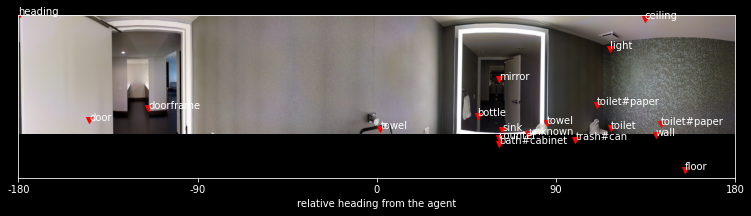

In [25]:
plt.close('all')
viewpoint_heading = np.pi / 6
# for n, (viewpoint, heading, elevation) in enumerate(trajectory['trajectory']):
plt.figure(figsize=(18, 3))
im = visualize_panorama_img(scan, viewpoint, viewpoint_heading, 0)    
plt.imshow(im)
plt.xticks(np.linspace(0, im.shape[1] - 1, 5), [-180, -90, 0, 90, 180])
plt.xlabel('relative heading from the agent')
plt.yticks([], [])

x0, y0 = viewpoint_heading, 0
for obj in objects.itertuples():
    heading, elevation = float(obj.heading), float(obj.elevation)
    category = obj.category_mapping_name

    heading -= x0
    while heading > np.pi:
        heading -= 2 * np.pi
    while heading < -np.pi:
        heading += 2 * np.pi

    first_coord = (heading / (2 * np.pi) + 0.5) * im.shape[1]

    # print(heading / (2 * np.pi), first_coord, im.shape)

    # second_coord = im.shape[1] * (1 + elevation / (np.pi / 4)) - y0
    second_coord = (1 - elevation / (np.pi / 2) - 0.5) * im.shape[0]

    plt.plot(first_coord, second_coord, color='red', marker='v', linewidth=3)
    plt.annotate(category, (first_coord, second_coord))

plt.plot(x0, y0, color='red', marker='v', linewidth=3)
plt.annotate('heading', (x0, y0))
        

        